In [1]:
"""
Multi-Channel Speech Presence Probability
==============

----------


.. [1] M. Souden, J. Chen, J. Benesty and S. Affes, "Gaussian Model-Based Multichannel Speech Presence Probability,"
    in IEEE Transactions on Audio, Speech, and Language Processing, vol. 18, no. 5, pp. 1072-1077, July 2010,
    doi: 10.1109/TASL.2009.2035150.
   [2] Bagheri, S., Giacobello, D. (2019) Exploiting Multi-Channel Speech Presence Probability in Parametric
    Multi-Channel Wiener Filter. Proc. Interspeech 2019, 101-105, DOI: 10.21437/Interspeech.2019-2665
   [3] M. Souden, J. Chen, J. Benesty and S. Affes,"An Integrated Solution for Online Multichannel Noise Tracking and Reduction,"

"""

import os

import numpy as np
from pesq import pesq
from pystoi.stoi import stoi

import librosa
import matplotlib.pyplot as plt
from DistantSpeech.transform.transform import Transform
from DistantSpeech.beamformer.utils import pmesh, mesh, load_wav, save_audio, load_pcm
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.beamformer import beamformer
from DistantSpeech.beamformer.MicArray import MicArray, compute_tau
from DistantSpeech.noise_estimation import McSpp

In [2]:
# %matplotlib notebook

The RT60 is 82 ms
(6, 316761)
(257, 1244, 6)
(257, 1237, 6)


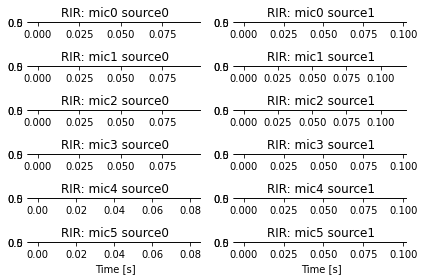

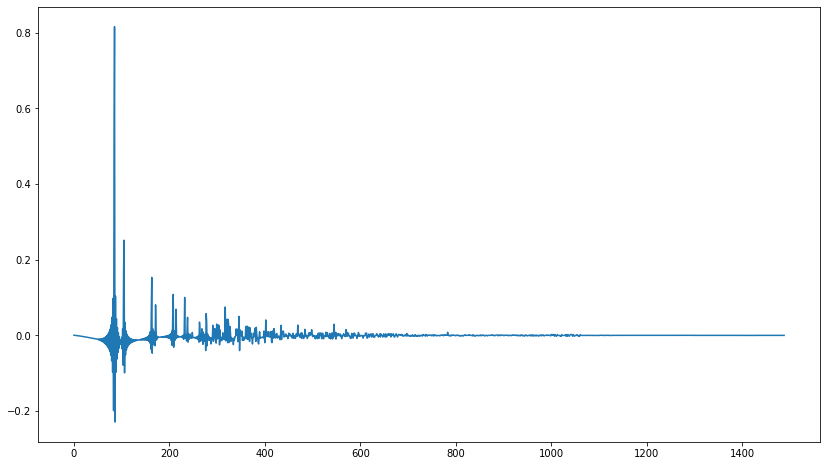

In [3]:


sampling_frequency = 16000
fft_length = 512
fft_shift = 256
mic_diameter = 0.1
sound_speed = 343
look_direction = 30

signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/5_541_20170608093550_3.wav")
# signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav")
noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office3.wav")
fs = 16000
M = 6
mic_array = MicArray(arrayType="circular", r=mic_diameter/2, M=M, n_fft=512)
mic_array_sim = mic_array.array_sim
# print(mic_array_sim.R)
array_data, premix = mic_array_sim.generate_audio(signal, interference=noise, source_angle=look_direction, interf_angle=270, sir=0, snr=120)
theoretical=True
audiowrite('mix.wav', np.transpose(array_data))
# audiowrite('signal.wav', np.transpose(premix[0, :, :]))
# audiowrite('interf.wav', np.transpose(premix[1, :, :]))

print(array_data.shape)
M = array_data.shape[0]
transform = Transform(n_fft=512, hop_length=256, channel=M)
D = transform.stft(np.transpose(array_data))
transform = Transform(n_fft=512, hop_length=256, channel=M)
target = transform.stft(np.transpose(premix[0, :M, :]))
transform = Transform(n_fft=512, hop_length=256, channel=M)
Noise = transform.stft(np.transpose(premix[1, :M, :]))
print(Noise.shape)
half_bin = D.shape[0]
frame_num = D.shape[1]
print(D.shape)
plt.figure(figsize=(14,8))
plt.plot(mic_array_sim.room.rir[0][0])
plt.show()

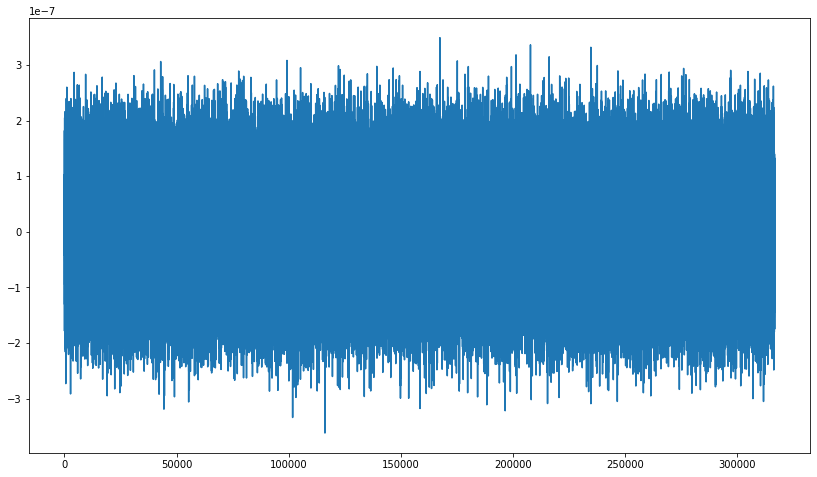

In [4]:
plt.figure(figsize=(14,8))
plt.plot(array_data[0, :] - premix[1, 0, :array_data.shape[1]] - premix[0, 0, :array_data.shape[1]])
plt.show()

In [5]:
# audiowrite('/home/wangwei/work/DistantSpeech/example/test_audio/sim/mix3/mix.wav', np.transpose(array_data))
# audiowrite('/home/wangwei/work/DistantSpeech/example/test_audio/sim/mix3/signal.wav', np.transpose(premix[0, :, :]))
# audiowrite('/home/wangwei/work/DistantSpeech/example/test_audio/sim/mix3/interf.wav', np.transpose(premix[1, :, :]))

(257, 1237, 6)


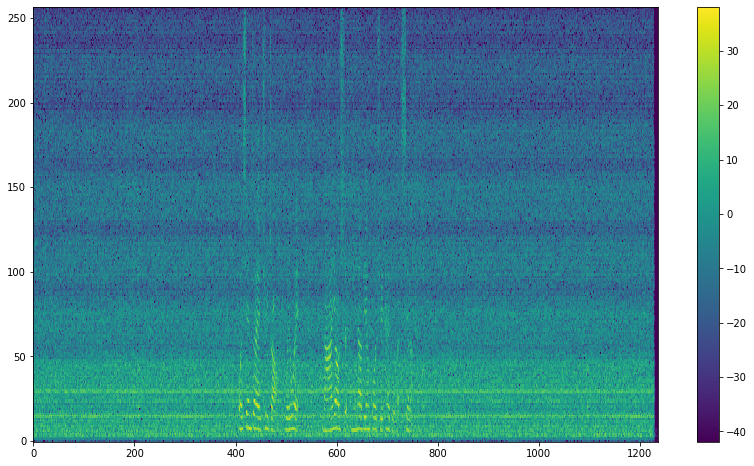

In [6]:

sr = 16000
r = 0.032
c = 343

frameLen = 256
hop = frameLen / 2
overlap = frameLen - hop
nfft = 256
c = 340
r = 0.032
fs = sr

# pampath = '/home/wangwei/work/DistantSpeech/samples/bookself/1'
# # pampath = '/home/wangwei/work/corpus/kws/lanso/record_test/meetingroom/20220106/pcm'
# array_data = load_pcm(pampath)

# filepath = "test_audio/rec1/"
# array_data, sr = load_wav(os.path.abspath(filepath))      # [channel,samples]

# wavpath = '/home/wangwei/work/Beamforming-for-speech-enhancement-master/sample_data'
# array_data, _ = load_wav(wavpath)
# array_data = array_data[:M, :]

# wavpath = '/home/wangwei/work/DistantSpeech/samples/audio_samples/xmos/rain/wav'
wavpath = '/home/wangwei/work/DistantSpeech/samples/audio_samples/xmos/meeting/1/wav'
# wavpath = '/home/wangwei/work/DistantSpeech/samples/audio_samples/xmos/rec1'
# wavpath = '/home/wangwei/work/DistantSpeech/samples/audio_samples/xmos/anechoic/wav'

# array_data, _ = load_wav(wavpath)
# array_data = array_data[:M, :]
# mic_array = MicArray(arrayType="circular", r=0.032, M=4, n_fft=512)
# theoretical = False
# M = array_data.shape[0]


transform = Transform(n_fft=512, hop_length=256, channel=M)
D = transform.stft(np.transpose(array_data))
# transform = Transform(n_fft=512, hop_length=256, channel=M)
# Noise = transform.stft(np.transpose(premix[1, ...]))

# # D = D[:, :790, :]
# # Noise = Noise[:, :790, :]
# print(Noise.shape)
Y, _ = transform.magphase(D, 2)
print(D.shape)
pmesh(librosa.power_to_db(Y[:, :, 0]))
# audiowrite('mix3.wav', np.transpose(array_data))
# audiowrite('target.wav', np.transpose(premix[0, :, :]))
# audiowrite('interf.wav', np.transpose(premix[1, :, :]))

In [7]:
channel = M
mcspp = McSpp(nfft=512, channels=channel, mic_array=mic_array)
mcspp.mcra.L = 15

p = np.zeros((half_bin, Y.shape[1]))
q = np.zeros((half_bin, Y.shape[1]))

Yout = np.zeros((Y.shape[0], Y.shape[1]), dtype=complex)
Yout1 = np.zeros((Y.shape[0], Y.shape[1]), dtype=complex)
w_n = np.zeros((half_bin, M), dtype=complex)

alpha_xx = mcspp.alpha
alpha_vv = mcspp.alpha
Phi_xx_th = np.zeros((half_bin, M, M), dtype=complex)
Phi_xx_all_th = np.zeros((half_bin, Y.shape[1]))
Phi_xx_all = np.zeros((half_bin, Y.shape[1]))
Phi_vv_th = np.zeros((half_bin, M, M), dtype=complex)
Phi_vv_inv_th_lemma = np.zeros((half_bin, M, M), dtype=complex)

xi_th = np.zeros((half_bin, Y.shape[1])) # theoretical
gamma_th = np.zeros((half_bin, Y.shape[1])) # theoretical
xi = np.zeros((half_bin, Y.shape[1])) # estimated
gamma_est = np.zeros((half_bin, Y.shape[1])) # estimated
xi_local_th = np.zeros((half_bin, Y.shape[1])) # theoretical

noise_c_th = np.zeros((half_bin, Y.shape[1])) # theoretical
noise_v13_th = np.zeros((half_bin, Y.shape[1])) # theoretical
noise_th = np.zeros((half_bin, Y.shape[1])) # theoretical
noise_inv_th = np.zeros((half_bin, Y.shape[1])) # theoretical
noise_c_inv_th = np.zeros((half_bin, Y.shape[1])) # theoretical
noisy_th = np.zeros((half_bin, Y.shape[1])) # theoretical

noise_est = np.zeros((half_bin, Y.shape[1])) # estimated
noise_c_est = np.zeros((half_bin, Y.shape[1])) # cross psd estimated
noise_v13_est = np.zeros((half_bin, Y.shape[1])) # cross psd estimated
noise_inv_est = np.zeros((half_bin, Y.shape[1])) # estimated


for n in range(Y.shape[1]):
    y = D[:, n, :] #[half_bin, M]

    diag_value = 1e-6
    p[:, n] = mcspp.estimation(y, diag_value=diag_value, repeat=True)
    q[:, n] = mcspp.q
    xi[:, n] = mcspp.xi
    gamma_est[:, n] = mcspp.gamma
    Phi_xx_all[:, n] = mcspp.Phi_xx[:, 0, 0].real
    # noise_est[:, n] = np.abs(np.trace(mcspp.Phi_vv, axis1=-2, axis2=-1))
    noise_est[:, n] = mcspp.Phi_vv[:, 0,0].real
    noise_c_est[:, n] = np.abs(mcspp.Phi_vv[:, 0,2])
    noise_inv_est[:, n] = np.abs(mcspp.Phi_vv_inv[:, 0, 2])
    # noise_inv_est[:, n] = np.abs(np.trace(mcspp.Phi_vv_inv, axis1=-2, axis2=-1))

    if theoretical:
        diag_value = 1e-6#1e-1
        diag = np.eye(mcspp.channels) * diag_value
        diag_bin = np.broadcast_to(diag, (mcspp.half_bin, mcspp.channels, mcspp.channels))
        # theoretical PSD
        noise = Noise[:, n, :] # [M, half_bin]
        target_n = target[:, n, :]
        psd_vv_th = np.einsum('ij,il->ijl', noise, noise.conj()) # [half_bin, M, M]
        Phi_vv_th = alpha_vv * Phi_vv_th + (1 - alpha_vv) * psd_vv_th # [half_bin, M,M]

        # psd_xx_th = np.einsum('ij,il->ijl', target_n, target_n.conj())
        # Phi_xx_th = alpha_xx * Phi_xx_th + (1 - alpha_xx) * psd_xx_th # [half_bin, M,M]

        Phi_xx_th = mcspp.Phi_yy - Phi_vv_th
        # for k in range(mcspp.half_bin):
        #     if (np.diag(Phi_xx_th[k]) < 0).any():
        #         Phi_vv_th[k] = mcspp.Phi_yy[k] - diag_bin[k] * 2
        #         Phi_xx_th[k] = diag_bin[k]

        # Phi_xx_th = mcspp.Phi_yy - Phi_vv_th
        # Phi_xx_all_th[:, n] = Phi_xx_th[:, 0, 0].real



        Phi_vv_inv_th = np.linalg.inv(Phi_vv_th + diag_bin)
        # psd_vv_inv_th = np.linalg.inv(psd_vv_th + diag_bin)

        xi_th[:, n] = np.trace(np.real(Phi_vv_inv_th @ Phi_xx_th), axis1=-2, axis2=-1)
        # xi_local_th_bin = np.trace(np.real(psd_vv_inv_th_bin@psd_xx_th), axis1=-2, axis2=-1)
        # xi_local_th[:,n] = (np.abs(psd_xx_th[:,0,0]))/((np.abs(psd_vv_th[:,0,0]))+diag_value)
        # xi_local_th[:,n] = np.trace(np.real(psd_vv_inv_th_bin@psd_xx_th), axis1=-2, axis2=-1)

        gamma_th[:, n] = (
            y[:, None, :].conj() @ Phi_vv_inv_th @ Phi_xx_th @ Phi_vv_inv_th @ y[:, :, None]
        ).real.squeeze()
        # index = np.where(xi_th[:, n] < 0)
        # Phi_vv_th[index] = np.linalg.inv(mcspp.Phi_yy[index] + diag_bin[index])

        noisy_th[:, n] = np.abs(mcspp.Phi_yy[:, 0, 0].real)
        noise_th[:, n] = Phi_vv_th[:, 0, 0].real
        # noise_th[:, n] = np.abs(np.trace(Phi_vv_th, axis1=-2, axis2=-1))
        noise_c_th[:, n] = np.abs(Phi_vv_th[:, 0,2])
        # noise_v13_th[:, n] = np.abs(Phi_vv_th[0,2,:])
        noise_inv_th[:, n] = np.abs(Phi_vv_inv_th[:, 0, 2])
        # noise_inv_th[:, n] = np.abs(np.trace(Phi_vv_inv_th_bin, axis1=-2, axis2=-1))
    


    # for k in range(mcspp.half_bin):
    #     eig_value, eig_vector = np.linalg.eigh(mcspp.Phi_xx[:, :, k])
    #     # max_index = np.argmax(eig_value)
    #     # steer_vector = eig_vector[:, max_index:max_index+1]
    #     steer_vector = eig_vector[:, -1:0]
    #     Rxx_r1 = steer_vector @ steer_vector.conj().T
    #     sigma_x = np.trace(mcspp.Phi_xx[:, :, k])/(np.trace(Rxx_r1) + 1e-6)
    #     Rxx_r1 = sigma_x*Rxx_r1
    #     xi[:, n] = np.trace(Rxx_r1).real
    

    
    if n == 180:
        w_n[:] = mcspp.w
    w_scale = 1 - 1 / (1 + mcspp.xi) ** mcspp.p ** (1 / mcspp.p) # eq.28 in [3]
    Yout[:, n] = np.sum(y*mcspp.w.conj(), axis=1)
    Yout1[:, n] = np.sum(y*mcspp.w.conj(), axis=1)*w_scale



In [8]:
np.min(Phi_xx_all_th)
# np.where(Phi_xx_all< 0)

0.0

In [9]:
yout = transform.istft(Yout)
yout1 = transform.istft(Yout1)
audiowrite('rec111.wav', yout)
audiowrite('rec111_1.wav', yout1)

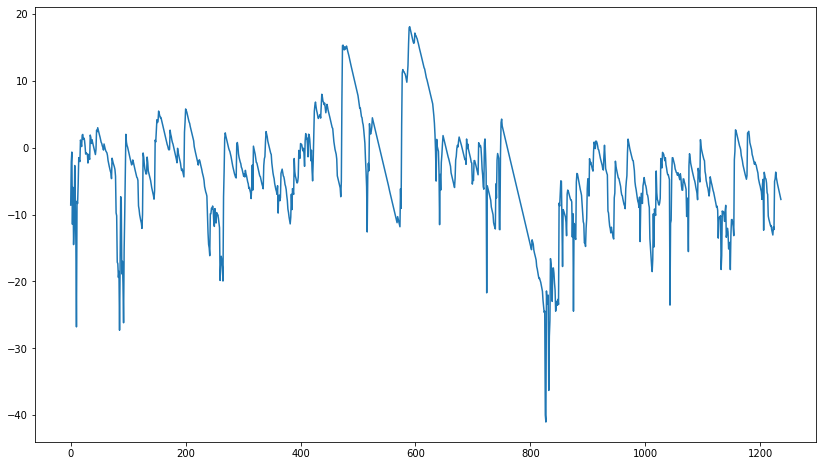

0.0
0.0


In [10]:
target_diff = librosa.power_to_db(np.abs(Phi_xx_all-Phi_xx_all_th))
plt.figure(figsize=(14,8))
plt.plot(target_diff[32, :])
plt.show()
# pmesh(librosa.power_to_db(Phi_xx_all_th))
# pmesh(librosa.power_to_db(Phi_xx_all))
# noise_diff = librosa.power_to_db(np.abs(noise_inv_est))-librosa.power_to_db(np.abs(noise_inv_th))
# print(noise_diff.shape)
# # pmesh(noise_diff)
# plt.figure(figsize=(14,8))
# plt.plot(noise_diff[32, 0:])
# plt.show()

# plt.figure(figsize=(14,8))
# plt.plot(librosa.power_to_db(xi_local_th[30,:1200]))
# # plt.plot(np.maximum(xi_local_th[32,:], 1e-6))
# # plt.title('xi local th')
# plt.show()
print(np.min(xi_local_th[30,:]))
print(np.max(xi_local_th[30,:]))

# pmesh(librosa.power_to_db(xi_local_th))



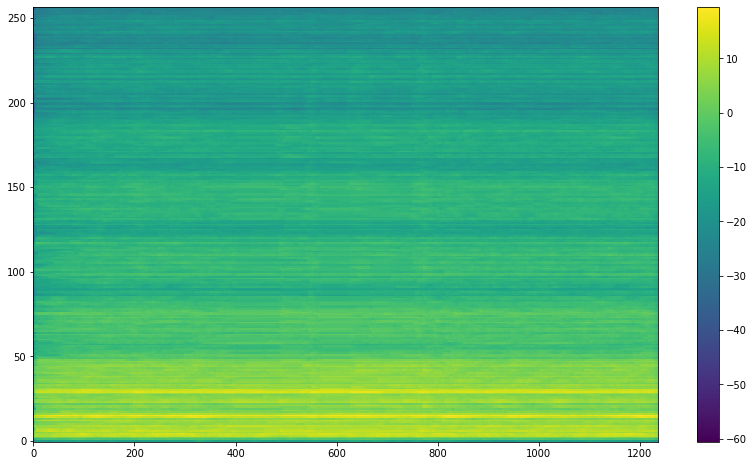

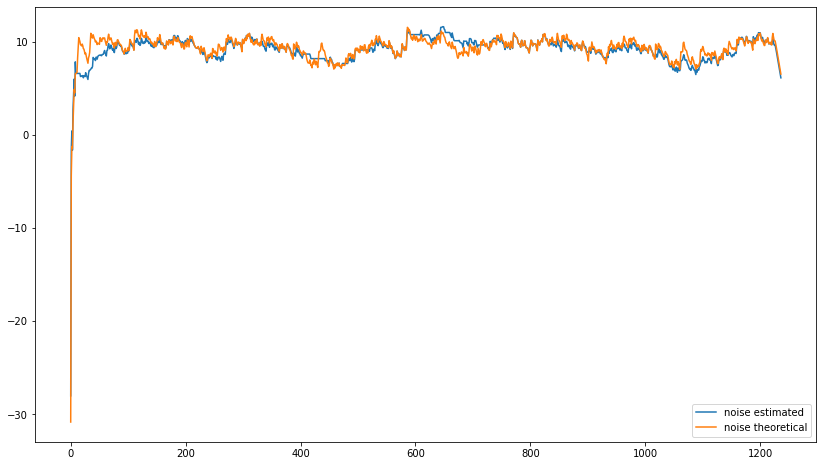

439434.34253269323
0.28719111462693114


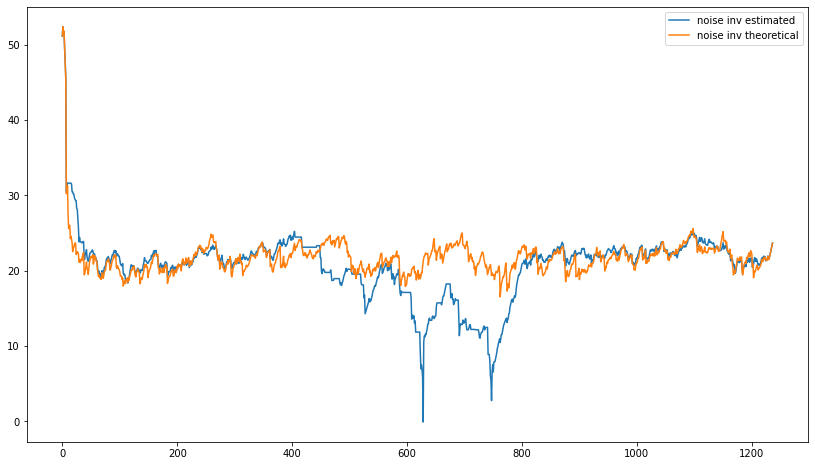

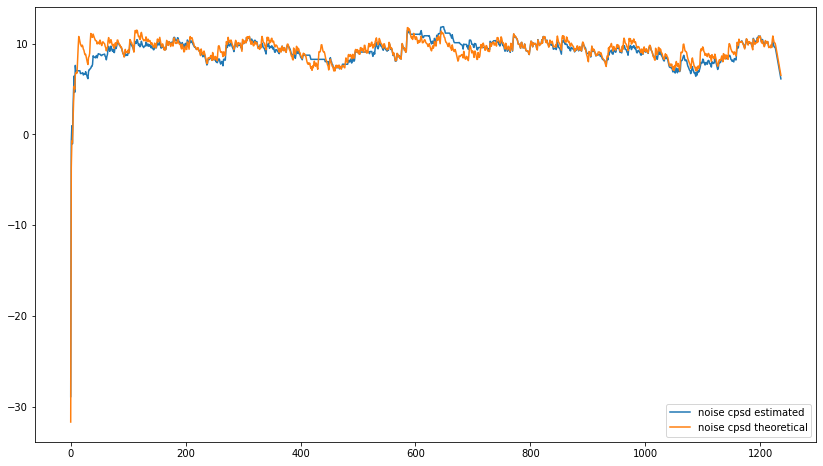

In [11]:

pmesh(librosa.power_to_db(noise_est))
plt.figure(figsize=(14, 8))
plt.plot((librosa.power_to_db(noise_est[16, :])))
plt.plot((librosa.power_to_db(noise_th[16, :])))

plt.legend(['noise estimated', 'noise theoretical'])
# plt.ylim([10,30])
plt.show()

print(np.max(noise_inv_est))
print(np.min(noise_inv_est))
plt.figure(figsize=(14, 8))
plt.plot((librosa.power_to_db(noise_inv_est[16, :])))
plt.plot((librosa.power_to_db(noise_inv_th[16, :])))
plt.legend(['noise inv estimated', 'noise inv theoretical'])
# plt.ylim([-20,])
plt.plot()
plt.show()

plt.figure(figsize=(14, 8))
plt.plot((librosa.power_to_db(noise_c_est[16, :])))
plt.plot((librosa.power_to_db(noise_c_th[16, :])))
plt.legend(['noise cpsd estimated', 'noise cpsd theoretical'])
# plt.ylim([10,30])
plt.plot()
plt.show()

In [12]:
# plt.figure(figsize=(14, 8))
# size = q.shape
# Y = np.arange(0, size[0], 1)
# X = np.arange(0, size[1], 1)
# X, Y = np.meshgrid(X, Y)

# im = plt.pcolormesh(X, Y, q, shading='auto')

# plt.colorbar(im)
# plt.show()
# plt.savefig('q1.png')

0.0
21.31396877546743


/tmp/ipykernel_36243/689218945.py:24: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig1)


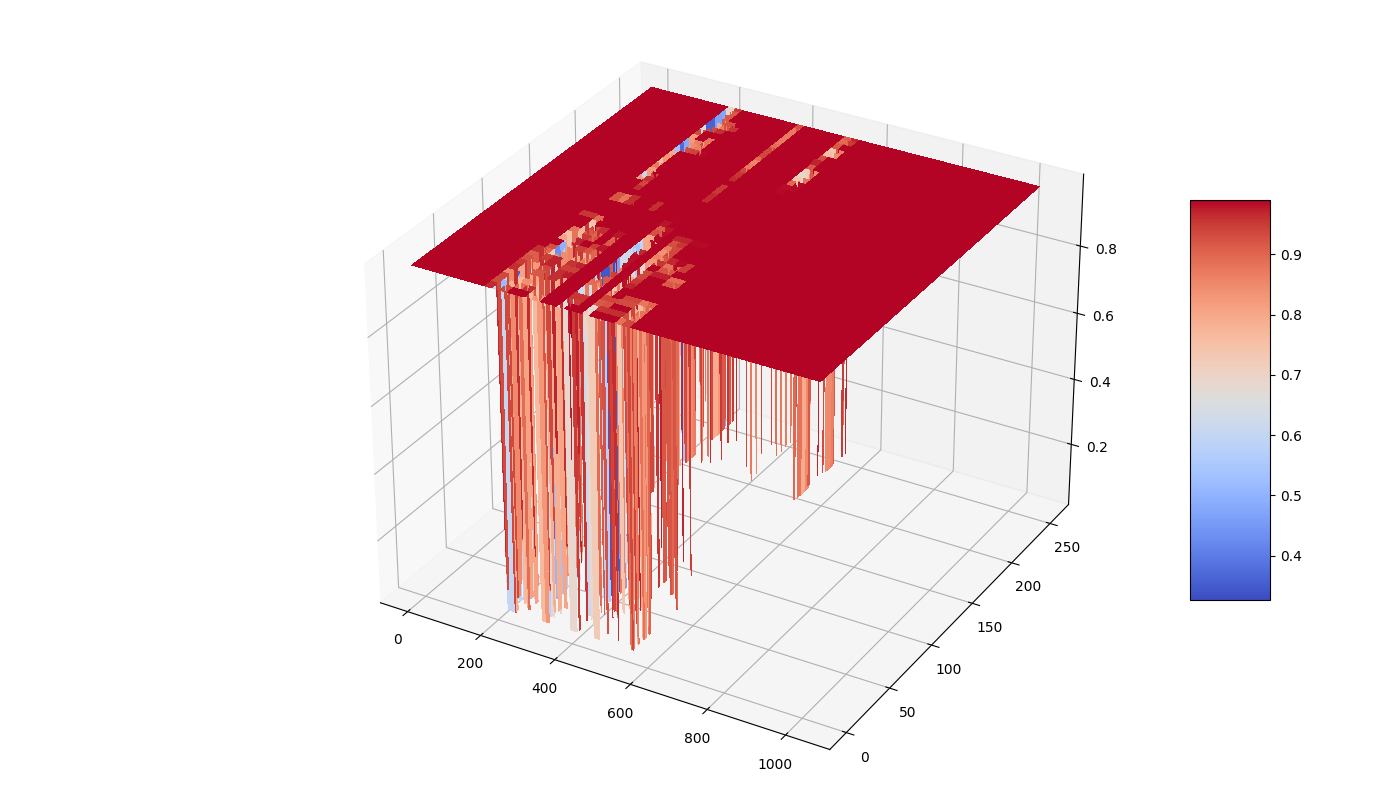

In [13]:
print(xi_local_th[32,250])
print(np.mean(np.abs(D[30,:500, 0])**2)) #[half_bin, M]
# print((1-q[30,:]**6)*2)
plt.figure(figsize=(14, 8))
# plt.plot((1-q[30,:]**6)*2)
# plt.plot(abs(D[30, :, 0])**2)
plt.plot(q[32,800:])
# pmesh((1-q**6)*2)
# pmesh(q)
# pmesh(p)


from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook
%matplotlib ipympl
array2D=q[:, 200:]
size = array2D.shape
Y = np.arange(0, size[0], 1)

X = np.arange(0, size[1], 1)
X, Y = np.meshgrid(X, Y)
fig1 = plt.figure(figsize=(14, 8))
ax = Axes3D(fig1)
surf = ax.plot_surface(X, Y, array2D, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig1.colorbar(surf, shrink=0.5, aspect=5)
plt.show()



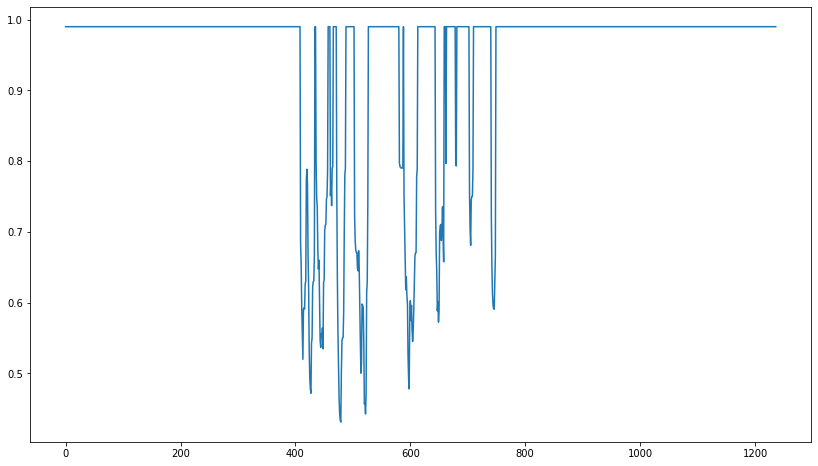

In [14]:
%matplotlib inline
plt.figure(figsize=(14,8))
plt.plot(np.mean(q[8:32, :], axis=0))
plt.show()

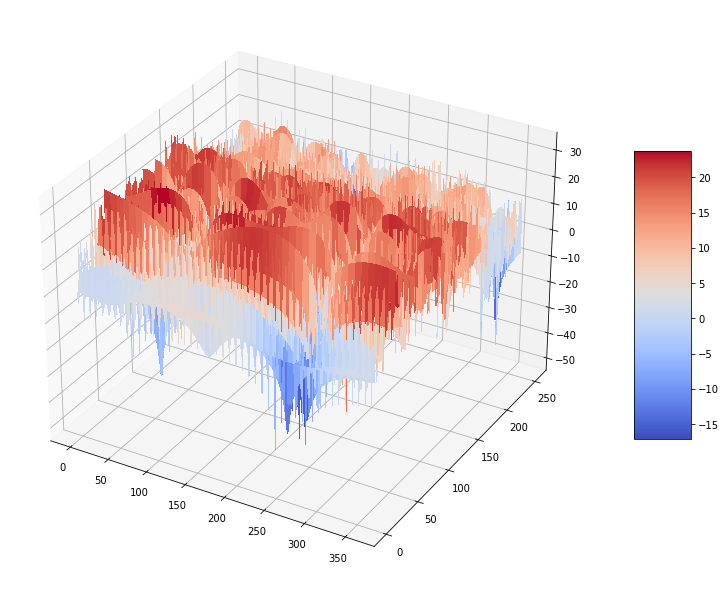

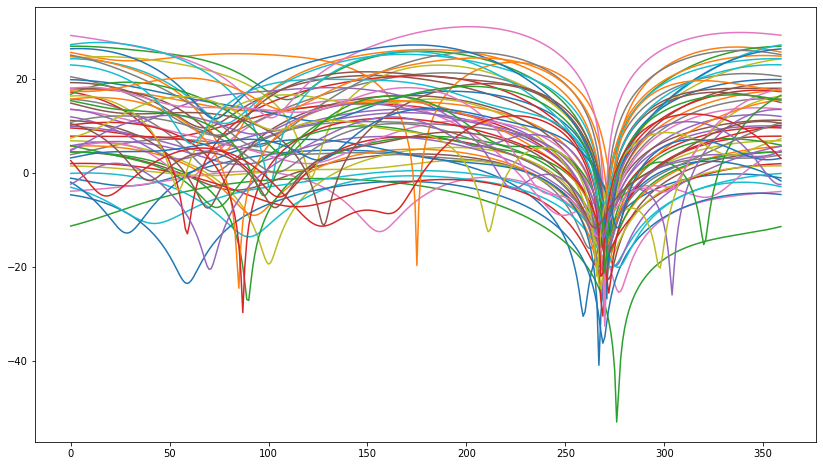

In [15]:
%matplotlib inline
beamformer_obj = beamformer(mic=mic_array, frame_len=512)
beamout = beamformer_obj.compute_beampattern(mic_array, weights=w_n.T)
mesh(beamout[:, 2:-2].T)

plt.figure(figsize=(14, 8))
plt.plot(beamout[:, 8:64])
plt.show()


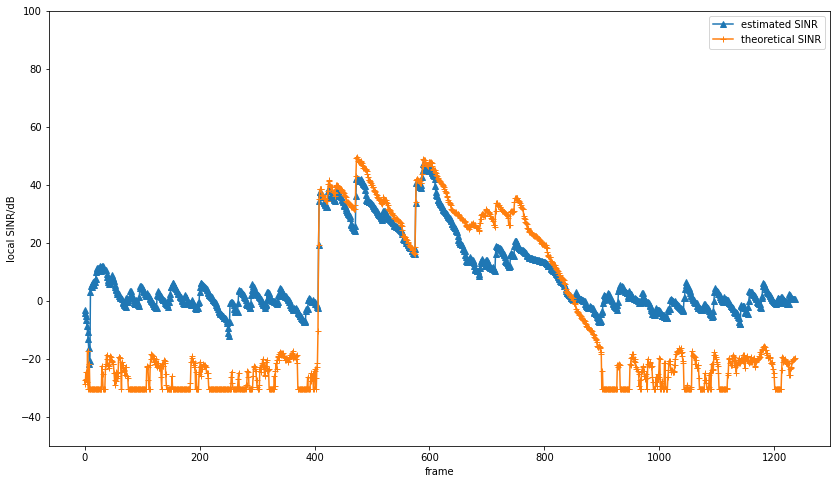

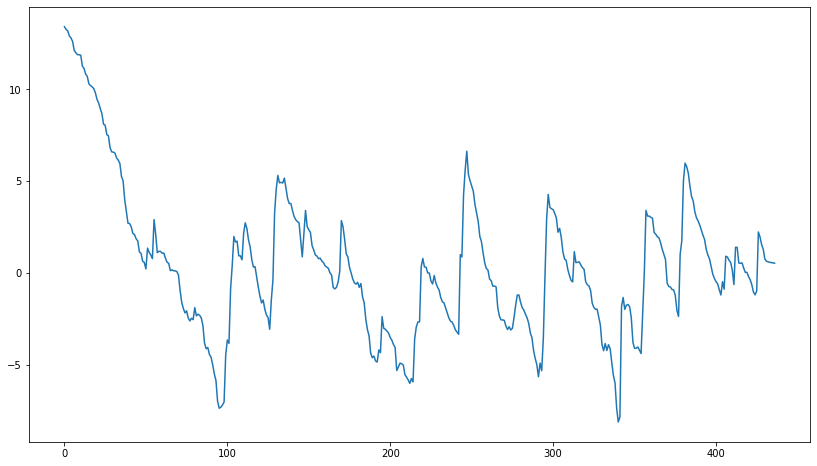

In [16]:
plt.figure(figsize=(14, 8))
# plt.plot(librosa.power_to_db(np.minimum(xi[32, 800:], 100)))
plt.plot(librosa.power_to_db(xi[32,:]), marker="^")
plt.plot(librosa.power_to_db(xi_th[32,:]), marker="+")
# plt.plot(librosa.power_to_db(np.abs(xi_th[32,:]-xi[32,:])), marker="*")

# plt.plot((xi[32,:]), marker="^")
# plt.plot((xi_th[32,:]), marker="+")

plt.xlabel('frame')
plt.ylabel('local SINR/dB')
plt.ylim([-50,100])
plt.legend(['estimated SINR', 'theoretical SINR', 'diff'])
plt.show()

plt.figure(figsize=(14, 8))
plt.plot(librosa.power_to_db(np.minimum(xi[32, 800:], 100)))
plt.show()

In [17]:
print(np.min(xi_local_th))
print(np.max(xi_local_th))

0.0
0.0


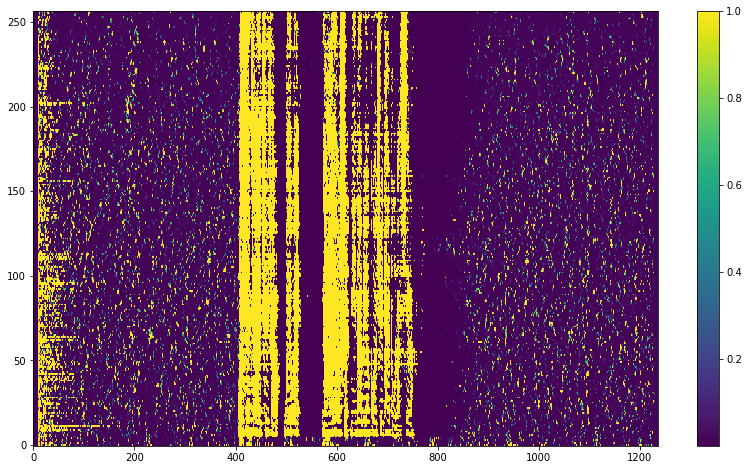

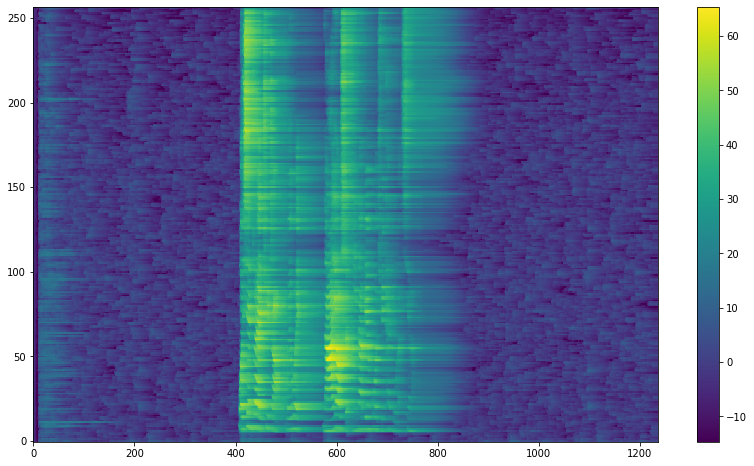

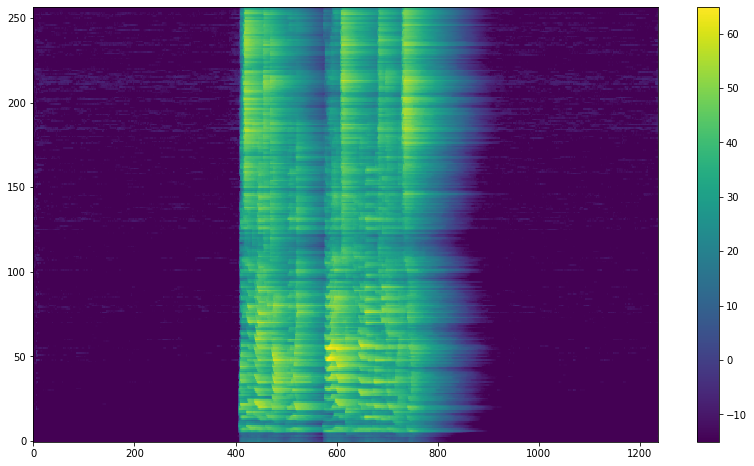

In [18]:
pmesh(p)
pmesh(librosa.power_to_db(xi))
pmesh(librosa.power_to_db(xi_th))
# pmesh(librosa.power_to_db(xi_local_th))

In [19]:
nsy = array_data[0, :]
ref = signal
# enh = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office1.wav")
# enh = audioread("/home/wangwei/work/DistantSpeech/example/out2.wav")

enh = yout[256:]
nsy = nsy[: len(enh)]
ref = ref[: len(enh)]

offset = 20480 # skip unconverge segment
enh = enh[offset:]
nsy = nsy[offset:]
ref = ref[offset:]

summary = {
    'ref_pesq_wb': pesq(sr, ref, nsy, 'wb'),
    'enh_pesq_wb': pesq(sr, ref, enh, 'wb'),
    'ref_pesq_nb': pesq(sr, ref, nsy, 'nb'),
    'enh_pesq_nb': pesq(sr, ref, enh, 'nb'),
    'ref_stoi': stoi(ref, nsy, sr, extended=False),
    'enh_stoi': stoi(ref, enh, sr, extended=False),
    'ref_estoi': stoi(ref, nsy, sr, extended=True),
    'enh_estoi': stoi(ref, enh, sr, extended=True),
}
for key in summary.keys():
    print('{}:{}'.format(key, summary[key]))

ref_pesq_wb:1.0711619853973389
enh_pesq_wb:2.1527204513549805
ref_pesq_nb:1.3023117780685425
enh_pesq_nb:3.221588373184204
ref_stoi:0.7825498338965885
enh_stoi:0.9045209230178755
ref_estoi:0.5927693914367714
enh_estoi:0.8602017688316386


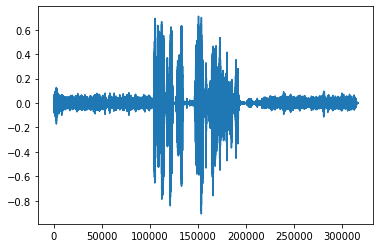

In [20]:
plt.figure()
plt.plot(yout[:-1])
plt.show()

In [21]:
print(np.isnan(ref).all())

False
